# Section 2.4.2: Eigenvector projections and subspace methods

This page contains the example of estimating eigenspace correlation of the sample covariance model, in the **fully separable** case.

## Contents

    - Empirical eigenvalues of $\frac1n X X^T$ versus limiting spectrum
    - Empirical eigenspace correlation
    - Estimation of eigenspace correlation with rectangular contour
    - Estimation of eigenspace correlation with line integrals (simplified from contour integration)
    - Application: "spiked" model eigenspace correlation

## Empirical eigenvalues of $\frac1n X X^T$ versus limiting spectrum

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
pi = np.pi

In [2]:
# FUNCTIONS
def SCM_func_inv(tilde_m, eig_C, cs, c):
#SCM_func_inv functional inverse of Stieltjes transform of large sample covariance model
#   INPUT: Stieltjes transform tilde_m, (k-discrete) eigenvalues of C, vector cs=p_a/p for a=1,...k, ratio c=p/n
#   OUTPUT: functional inverse x (of tilde_m) and its first derivative x_d

    assert len(eig_C) == len(cs),'Error: nb of (discrete) eigenvalues and nb of classes not equal!'

    x = -1/tilde_m
    x_d = 1/(tilde_m ** 2)

    for a in range(len(cs)):
        x   = x   + c*cs[a]*eig_C[a]/(1+eig_C[a]*tilde_m)
        x_d = x_d - c*cs[a]*eig_C[a]**2/(1+eig_C[a]*tilde_m)**2

    return x,x_d

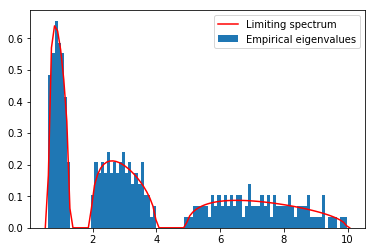

In [3]:
coeff = 3
p = 100*coeff
n = 1000*coeff
c = p/n

eig_C = [1,3,7]
cs = [1/3,1/3,1/3]
C = np.array(np.diag(np.concatenate([eig_C[0]*np.ones(int(p*cs[0])),eig_C[1]*np.ones(int(p*cs[1])),eig_C[2]*np.ones(int(p*cs[2]))]))) # population covariance
eigs_C,U = np.linalg.eig(C)
arg_sort = np.argsort(eigs_C)

eigs_C = eigs_C[arg_sort][::-1]
U = U[:,arg_sort][::-1]

Z = np.array(np.random.randn(p,n))
X = scipy.linalg.sqrtm(C) @ Z

SCM = X @ X.T/n # sample covariance matrix and its empirical spectral measure
eigs_SCM,hat_U = np.linalg.eig(SCM)
arg_sort      = np.argsort(eigs_SCM)

eigs_SCM = eigs_SCM[arg_sort][::-1]
hat_U = hat_U[:,arg_sort][::-1]

edges=np.linspace(np.min(eigs_SCM)-.1,np.max(eigs_SCM)+.1,100)

y  = 1e-5
zs = edges+y*1j
mu = []

tilde_m=0
for z in zs:

    tilde_m_tmp=-1
    while abs(tilde_m-tilde_m_tmp)>1e-6:
        tilde_m_tmp=tilde_m
        tilde_m = 1/( -z + 1/n*np.sum(eigs_C/(1+tilde_m*eigs_C)) )

    m = tilde_m/c+(1-c)/(c*z)
    mu.append(np.imag(m)/pi)

# limiting versus empirical spectral measure of SCM    
plt.hist(eigs_SCM,bins=edges,weights=1/p/(edges[1]-edges[0])*np.ones(p),label='Empirical eigenvalues')
plt.plot(edges,mu,'r',label='Limiting spectrum')
_ = plt.legend()


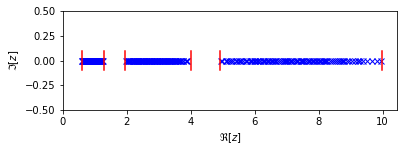

In [4]:
# ## Determine the support of $\mu$ via Theorem 2.10
Tol = 1e-3
search_min = -2
search_max = Tol
search_domain = np.linspace(search_min, search_max, 5000) # search domain of tilde_m

x_d = SCM_func_inv(search_domain, eig_C, cs, c)[1]
x_d_1 = x_d[:-1]
x_d_2 = x_d[1:]
zero_deri_index = [ i for i in range(len(x_d_1)) if x_d_1[i]*x_d_2[i]<0 ]
support_edges   = SCM_func_inv(search_domain[zero_deri_index], eig_C, cs ,c)[0]

if len(support_edges) != 2*len(eig_C):
    print('Error: nb of (discrete) eigenvalues and nb of support edges do not match!')


# compare estimated support with empirical eigenvalues
plt.subplot(2,1,2)
plt.plot(eigs_SCM,np.zeros(len(eigs_SCM)), 'bx')
for edge in support_edges:
    plt.plot(edge*np.ones(10), np.linspace(-.1,.1,10),'r')
plt.xlabel(r'$\Re[z]$')
plt.ylabel(r'$\Im[z]$')
plt.gca().set_xlim(0,np.max(eigs_SCM)+.5)
_ = plt.gca().set_ylim(-.5,.5)

## Empirical eigenspace correlation

In [5]:
emp_eig_corr = []

index = 0
for c_ in cs:
    U_spike = U[:,index:int(index+p*c_-1)]
    hat_U_spike = hat_U[:,index:int(index+p*c_-1)]
    emp_eig_corr.append(np.trace((hat_U_spike.T) @ U_spike @ (U_spike.T) @ hat_U_spike)/p/c_)
    index = int(index+p*c_)

print('Empirical eigenspace correlation:')
print(emp_eig_corr)

Empirical eigenspace correlation:
[0.9462726726192956, 0.9088257794427352, 0.9290540101289708]


## Estimation of eigenspace correlation with rectangular contour

In [6]:
estim_eig_corr = []

for a in range(len(cs)):
    popu_eig = eig_C[a]

    y_min = -1
    y_max = 1
    x_min = support_edges[2*a]-.1
    x_max = support_edges[2*a+1]+.1

    zs1 = np.arange(x_max,x_min,-.1) + y_max*1j
    zs2 = x_min + np.arange(y_max,y_min,-0.1)*1j
    zs3 = np.arange(x_min,x_max,0.1) + y_min*1j
    zs4 = x_max + np.arange(y_min,y_max,0.1)*1j

    zs = np.concatenate([zs1, zs2, zs3, zs4]) # rectangular contour

    integrand = []

    tilde_m=0
    for z in zs:
        
        tilde_m_tmp=-1
        while abs(tilde_m-tilde_m_tmp)>1e-6:
            tilde_m_tmp=tilde_m
            tilde_m = 1/( -z + 1/n*np.sum(eigs_C/(1+tilde_m*eigs_C)) )

        integrand.append(1/z/(1+tilde_m*popu_eig))

    estim_eig_corr.append(np.real(np.trapz(integrand,zs)/(pi*2j)))

print('Eigenspace correlation estimated with contour integration:')
print(estim_eig_corr)

Eigenspace correlation estimated with contour integration:
[0.9595787355023139, 0.9210649990219708, 0.9432862851095482]


## Estimation of eigenspace correlation with line integrals

In [7]:
estim_eig_corr = []

for a in range(len(cs)):

    xs = np.linspace(support_edges[2*a],support_edges[2*a+1], 500)
    popu_eig = eig_C[a]
    integrand = []

    tilde_m=0
    y = 1e-5
    for x in xs:
        z = x+y*1j

        tilde_m_tmp=-1
        while abs(tilde_m-tilde_m_tmp)>1e-6:
            tilde_m_tmp=tilde_m
            tilde_m = 1/( -z + 1/n*np.sum(eigs_C/(1+tilde_m*eigs_C)))

        integrand.append(popu_eig*np.imag(tilde_m)/( 1 + 2*popu_eig*np.real(tilde_m) + popu_eig**2*abs(tilde_m)**2 )/pi/x)

    estim_eig_corr.append(np.trapz(integrand,xs))

print('Eigenspace correlation estimated with line integral:')
print(estim_eig_corr)

Eigenspace correlation estimated with line integral:
[0.9659005054384959, 0.9280615596047375, 0.9484570817306597]


## Application: "spiked" model eigenvalue correlation

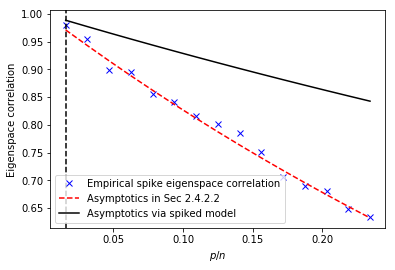

In [8]:
m_loop = np.array(range(15))+1
p_over_m = 16
n = 1024
c_loop = p_over_m*m_loop/n

emp_eig_corr = []
estim_eig_corr = []

np.random.seed(928)

for m in m_loop:
    p = int(p_over_m*m)
    c = p/n

    Z = np.mat(np.random.randn(p,n))

    eig_C = [1,2]
    cs = np.array([(p_over_m-1)/p_over_m, 1/p_over_m])
    C  = np.mat(np.diag(np.concatenate([eig_C[0]*np.ones((p_over_m-1)*m),eig_C[1]*np.ones(m)]))) # population covariance
    eigs_C,U = np.linalg.eig(C)
    
    arg_sort = np.argsort(eigs_C)
    eigs_C = eigs_C[arg_sort]
    U = U[:,arg_sort]
    
    
    X = scipy.linalg.sqrtm(C) @ Z

    SCM = X@(X.T)/n # sample covariance matrix and its empirical spectral measure
    eigs_SCM,hat_U = np.linalg.eig(SCM)

    arg_sort = np.argsort(eigs_SCM)
    eigs_SCM = eigs_SCM[arg_sort]
    hat_U = hat_U[:,arg_sort]
    
    edges=np.linspace(np.min(eigs_SCM)-.1,np.max(eigs_SCM)+.1,20)

    Tol = 1e-3
    search_min = -3
    search_max = Tol
    search_domain = np.linspace(search_min, search_max, 5000) # search domain of tilde_m

    x_d   = SCM_func_inv(search_domain, eig_C, cs, c)[1]
    x_d_1 = x_d[:-1]
    x_d_2 = x_d[1:]
    zero_deri_index = [ i for i in range(len(x_d_1)) if x_d_1[i]*x_d_2[i]<0 ]
    support_edges = SCM_func_inv(search_domain[zero_deri_index], eig_C, cs ,c)[0]

    # empirical evaluation of the "spike" eigenspace correlation
    U_spike = U[:,p-m:]
    hat_U_spike = hat_U[:,p-m:]
    emp_eig_corr.append(np.trace( (hat_U_spike.T) @ U_spike @ (U_spike.T) @ hat_U_spike)/m)

    # theory
    xs = np.linspace(support_edges[2],support_edges[3], 500)
    popu_eig = eig_C[1]
    integrand = []

    tilde_m=0
    y = 1e-5
    for x in xs:
        z = x+y*1j

        tilde_m_tmp=-1
        while abs(tilde_m-tilde_m_tmp)>1e-6:
            tilde_m_tmp=tilde_m
            tilde_m = 1/( -z + 1/n*np.sum(eigs_C/(1+tilde_m*eigs_C)) )

        integrand.append(popu_eig*np.imag(tilde_m)/( 1 + 2*popu_eig*np.real(tilde_m) + popu_eig**2*abs(tilde_m)**2 )/pi/x)

    estim_eig_corr.append(np.trapz(integrand,xs))

plt.plot(c_loop,emp_eig_corr,'bx',label=r'Empirical spike eigenspace correlation')
plt.plot(c_loop,estim_eig_corr,'r--',label=r'Asymptotics in Sec 2.4.2.2')
plt.plot(c_loop,(1-c_loop/4)/(1+c_loop/2),'k',label=r'Asymptotics via spiked model')
plt.axvline(x=c_loop[0],c='k',ls='--')
plt.xlabel(r'$p/n$')
plt.ylabel(r'Eigenspace correlation')
_ = plt.legend()